Données provenant de [https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2019/](https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2019/)

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates
import numpy as np
import json
import geopandas as gpd
from utils import getInputs, drawMap
import unidecode
import osmnx as ox
import os

plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2
# enable completion
%config Completer.use_jedi = False

## Preparation des données
Chargement du dictionnaire communes/code INSEE

In [3]:
dico_communes = json.load(open('input/dico_communes_insee.json', 'r'))

Selection des limites des communes d'intérêt (via code INSEE), et des routes correspondantes

In [105]:
communes = [
    'Clermont-Ferrand',
    'Aulnat',
    'Aubière',
    'Cébazat',
    'Chamalières',
#    'Beaumont',
    'Cournon d\'Auvergne',
#    'Royat',
#    'Le Cendre'
]

#communes = ['Clermont-Ferrand']
communes_insee = [dico_communes[unidecode.unidecode(c).upper()] for c in communes]

# get municipality boundaries
#metro = com[com.insee.isin(communes)]

# get roads
#route_clipped = gpd.clip(route, metro)

In [106]:
limites = ox.geocode_to_gdf(communes)

In [107]:
routes = gpd.GeoDataFrame()
for com, insee in zip(communes, communes_insee):
    print(com, insee)
    filename = f'input/routes/{insee}.geojson'
    if os.path.isfile(filename):
        r = gpd.read_file(filename)
    else:
        r = ox.geometries_from_place(com, tags={'highway':True})
        mask = r.highway.isin(['pedestrian', 'primary', 'primary_link', 'secondary', 'secondary_link',
                         'tertiary', 'tertiary_link', 'residential', 'motorway'])
        r = r[['geometry']][mask]
        r.to_file(filename)
    routes = routes.append(r)

Clermont-Ferrand 63113
Aulnat 63019
Aubière 63014
Cébazat 63063
Chamalières 63075
Cournon d'Auvergne 63124


Get accidents datatsets for years of interest

In [108]:
annee = [
#    '2019',
    '2020'
]
#annee = ['2019', '2018', '2017', '2016', '2015']

df_list = []
vehic_list = []
usager_list = []

for an in annee:
    df_sel, vehic_sel, usager_sel = getInputs(an, communes_insee)
    df_list.append(df_sel)
    vehic_list.append(vehic_sel)
    usager_list.append(usager_sel)

## Traçage des cartes

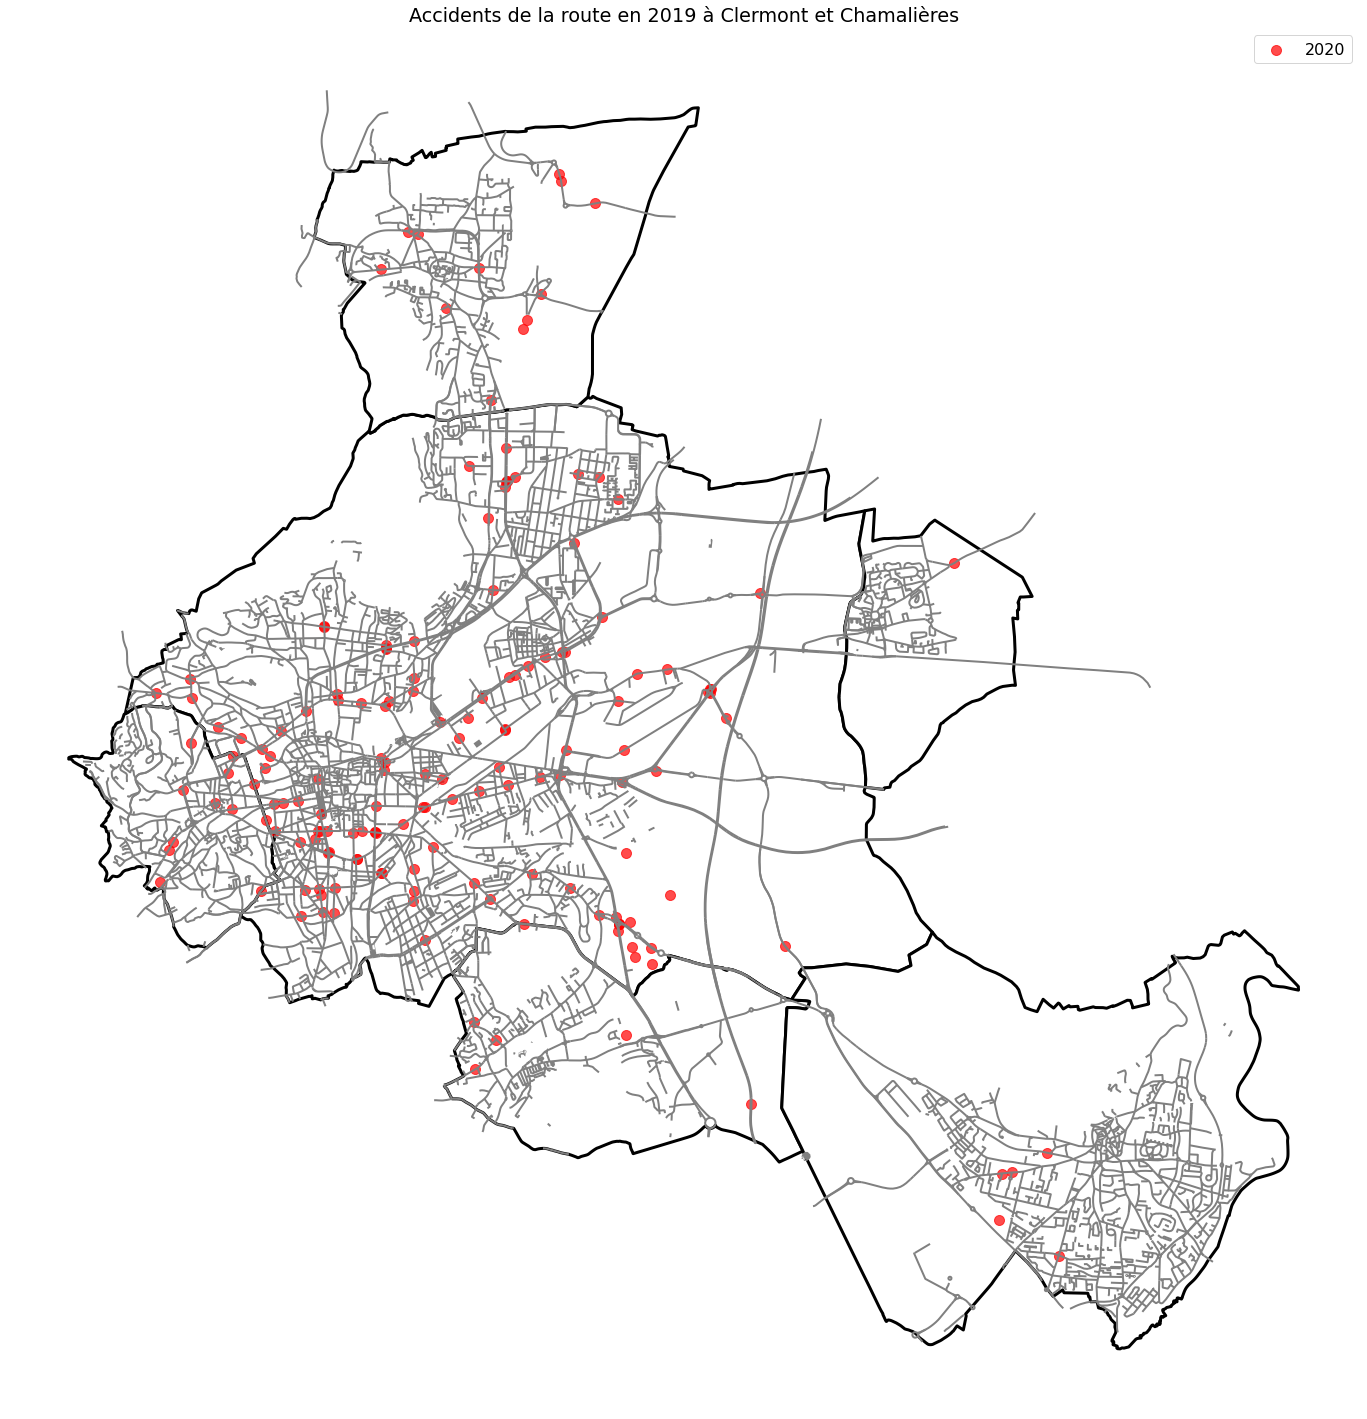

In [109]:
title = 'Accidents de la route en 2019 à Clermont et Chamalières'
drawMap(df_list, vehic_list, usager_list, annee, limites, routes, title)

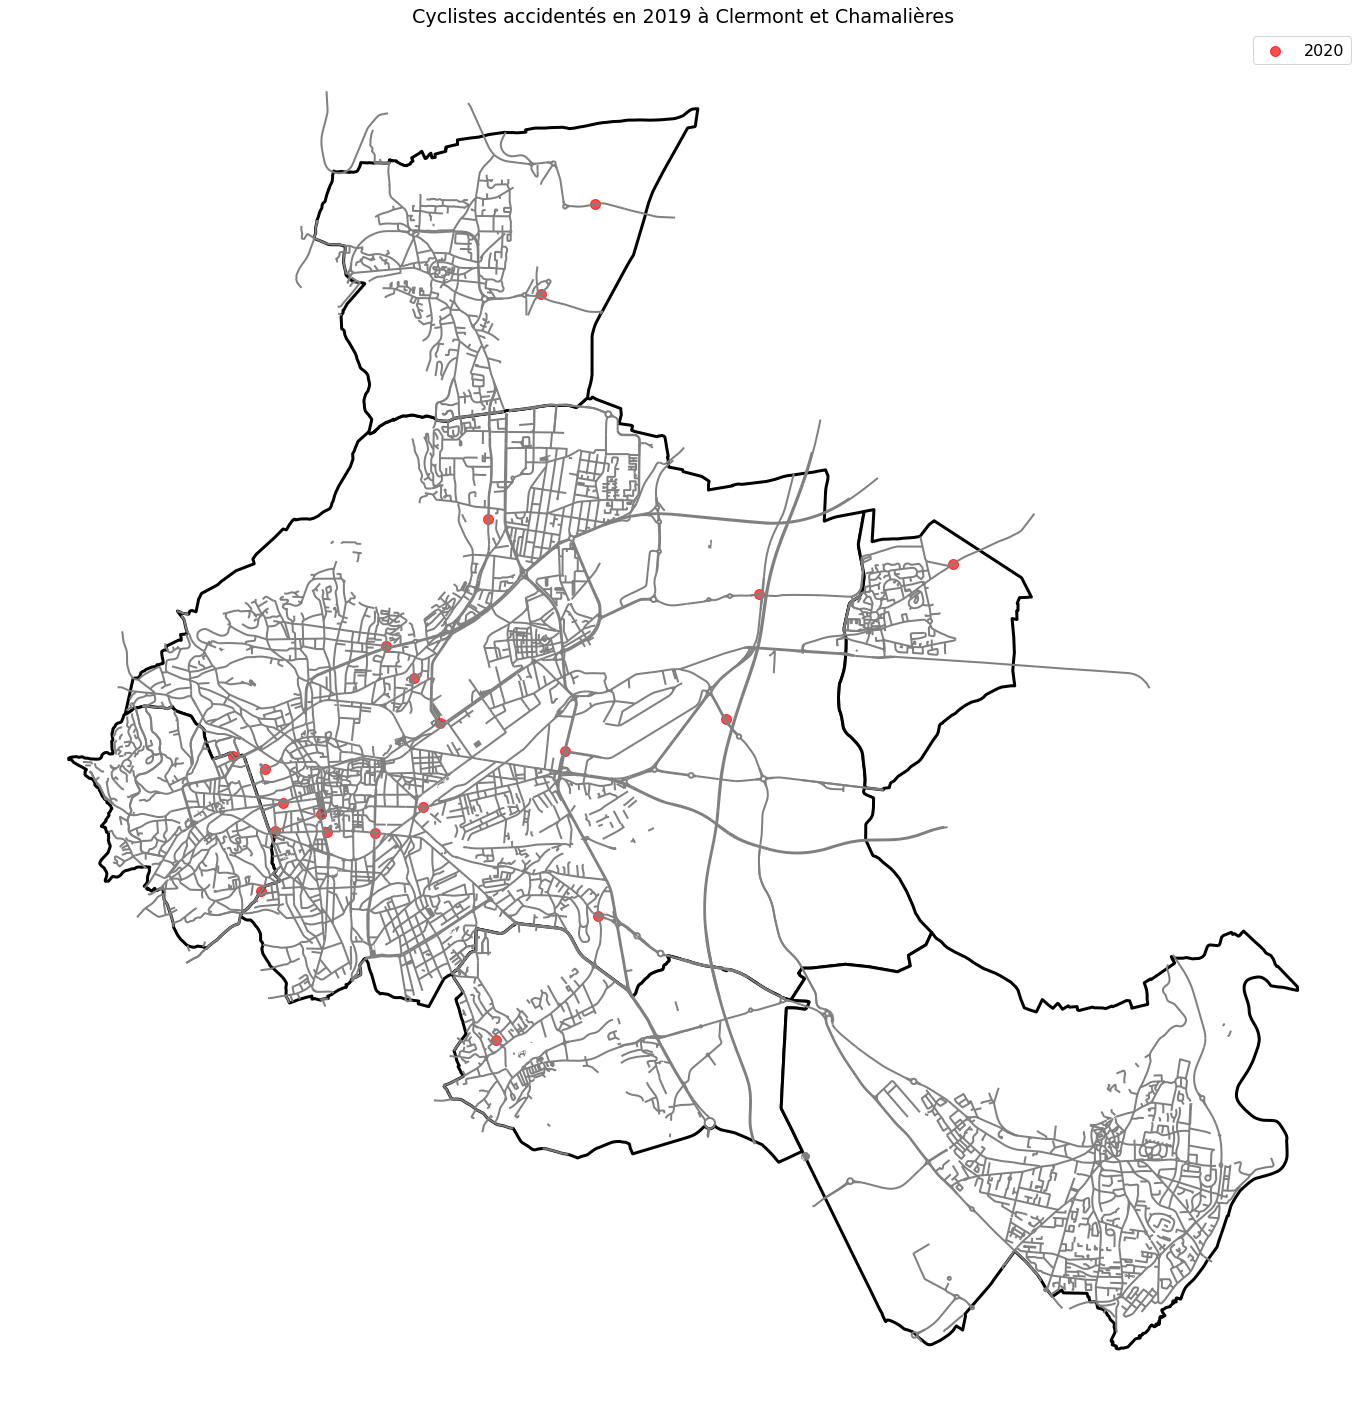

In [110]:
title = 'Cyclistes accidentés en 2019 à Clermont et Chamalières'
drawMap(df_list, vehic_list, usager_list, annee, limites, routes, title, vehic_type=1)

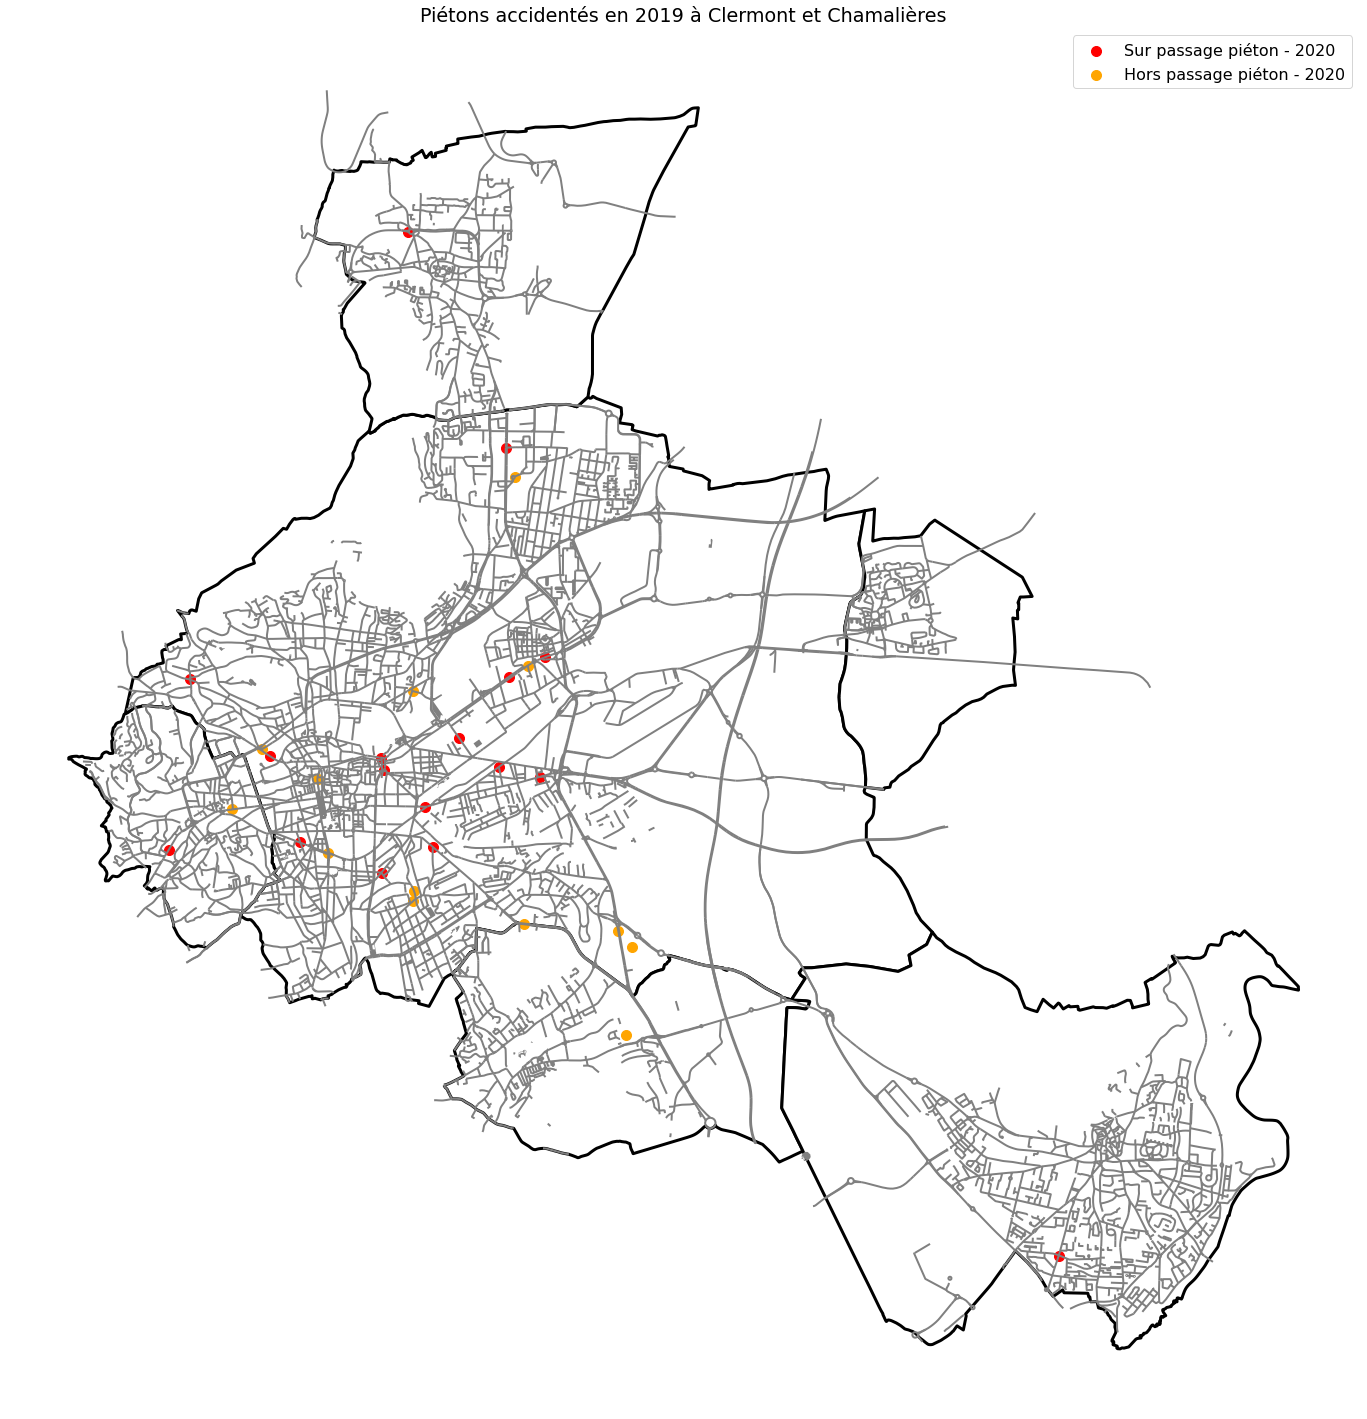

In [111]:
title = 'Piétons accidentés en 2019 à Clermont et Chamalières'
drawMap(df_list, vehic_list, usager_list, annee, limites, routes, title, usager_type=3)
plt.savefig('pietons.jpg')

## Analyse chiffrée (Clermont 2019)

### Nombre de collisions avec un piéton (obsm==1) pour chaque type de véhicule

In [4]:
vehic_list[0][vehic_list[0].obsm==1].catv.value_counts()

7     20
37     1
3      1
33     1
2      1
14     1
30     1
Name: catv, dtype: int64


|catv|7|10|14|30|37|40|
| --- | --- |  --- | --- | --- | --- | --- |
|véhicule|voiture|utilitaire|Poids lourd|scooter|bus|tramway|
|nombre|38|3|2|2|1|1|

### Type d'obstacle mobile heurté dans les accidents de vélo

In [5]:
vehic_list[0][vehic_list[0].catv==1].obsm.value_counts()

2    14
0     3
Name: obsm, dtype: int64


|obsm|0|2|
| --- | --- |  --- |
|obstacle|aucun|véhicule|
|nombre|16|2|

### Type d'obstacle fixe heurté dans les accidents de vélo

In [6]:
vehic_list[0][vehic_list[0].catv==1].obs.value_counts()

0     14
1      2
14     1
Name: obs, dtype: int64

|obsm|0|8|
| --- | --- |  --- |
|obstacle|aucun|poteau|
|nombre|17|1|

### Gravité des blessures des piétons accidentés

In [7]:
# selection des accidents impliquant des piétons pour le dataset sur les usagers
usager_pieton = usager_list[0][usager_list[0].catu==3]

In [8]:
usager_pieton.grav.value_counts()

4    15
3    14
2     1
Name: grav, dtype: int64

|grav|2|3|4|
| --- | --- |  --- | --- |
|Gravité|tué|blessé hospitalisé|blessé léger|
|nombre|1|17|30|

### Action du piéton

In [9]:
usager_pieton.actp.value_counts()

3    21
9     4
5     4
1     1
Name: actp, dtype: int64

|actp|1|3|5|9|B|
| --- | --- |  --- | --- | --- | --- |
|Action|dépacement dans le sens du véhicule heurtant|traversant|jouant/courant|autre|inconnue|
|nombre|1|39|3|3|2|

### Localisation du piéton

In [10]:
usager_pieton.locp.value_counts()

3    11
2     9
4     6
1     3
9     1
Name: locp, dtype: int64

|locp|0|1|2|3|4|5|9|
| --- | --- |  --- | --- | --- | --- | --- | --- |
|Location|sans objet|chaussée (+50m d'un passage piéton)|chaussée (-50m d'un passage piéton)|passage piéton (sans signalisation lumineuse)| passage piéton (avec signalisation lumineuse)|trottoir|inconnue|
|nombre|1|4|5|18|14|2|4|

In [11]:
import osmnx as ox

In [21]:
places = ['Clermont-Ferrand', 'Aulnat', 'Aubière', 'Cébazat']

In [22]:
city = ox.geocode_to_gdf(places)

In [24]:
ox.project_gdf(city)

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((504139.624 5070254.096, 504143.787 5...",45.818384,45.755694,3.172176,3.053256,281318008,relation,110866,45.777455,3.081943,"Clermont-Ferrand, Puy-de-Dôme, Auvergne-Rhône-...",boundary,administrative,0.813839
1,"POLYGON ((512314.716 5070451.529, 512321.131 5...",45.806811,45.777985,3.186887,3.158433,281318057,relation,111076,45.792446,3.171957,"Aulnat, Clermont-Ferrand, Puy-de-Dôme, Auvergn...",boundary,administrative,0.630050
2,"POLYGON ((507794.893 5066009.048, 507800.990 5...",45.764352,45.739698,3.154108,3.100213,281320582,relation,118479,45.751258,3.114419,"Aubière, Clermont-Ferrand, Puy-de-Dôme, Auverg...",boundary,administrative,0.640008
3,"POLYGON ((506295.085 5075686.900, 506373.417 5...",45.848040,45.814597,3.137692,3.081057,281331808,relation,110629,45.831157,3.106219,"Cébazat, Clermont-Ferrand, Puy-de-Dôme, Auverg...",boundary,administrative,0.635646


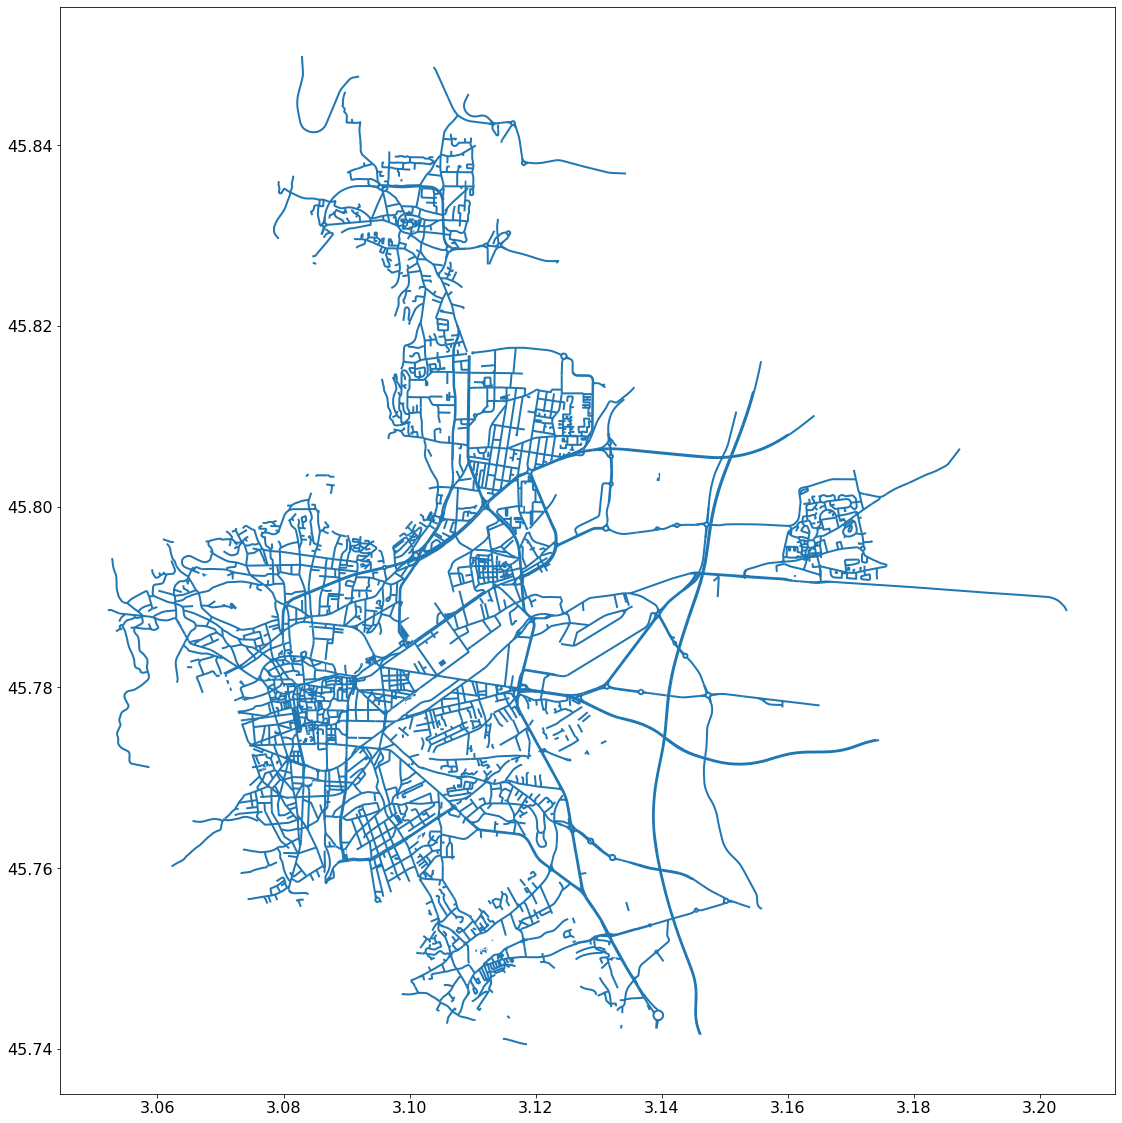

In [22]:
geo = ox.geometries_from_place(places, tags={'highway':True})
mask = geo.highway.isin(['pedestrian', 'primary', 'primary_link', 'secondary', 'secondary_link',
                         'tertiary', 'tertiary_link', 'residential', 'motorway'])
ax = geo[mask].plot()

In [26]:
type(city)

geopandas.geodataframe.GeoDataFrame